# Cartpole-v0 
# Shahid Gulzar Padder
# XPXSKK

0
0.999 )the system  has converged  after  690  episodes.
0.8 )the system  has converged  after  371  episodes.
0.7 )the system  has converged  after  134  episodes.
0.6 )the system  has converged  after  720  episodes.
0.5 )the system  has converged  after  277  episodes.
1
0.999 )the system  has converged  after  508  episodes.
0.8 )the system  has converged  after  417  episodes.
0.7 )the system  has converged  after  962  episodes.
0.6 )the system  has converged  after  591  episodes.
0.5 )the system  has converged  after  693  episodes.
2
0.999 )the system  has converged  after  282  episodes.
0.8 )the system  has converged  after  479  episodes.
0.7 )the system  has converged  after  872  episodes.
0.6 )the system  has converged  after  675  episodes.
0.5 )the system  has converged  after  854  episodes.
3
0.999 )the system  has converged  after  270  episodes.
0.8 )the system  has converged  after  525  episodes.
0.7 )the system  has converged  after  628  episodes.
0.6 )the sys

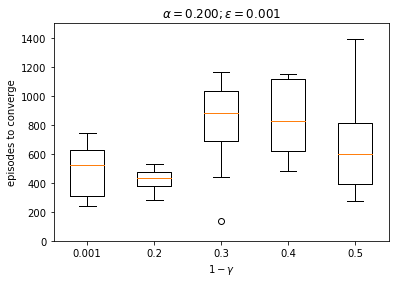

In [3]:
"""Q-learning algorithm implementation."""

import pandas
import numpy as np
import numpy.random as rnd
import gym
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt

def make_eps_greedy_policy(Q, eps, n):
    """Define a policy.
    Parameters
    ----------
    Q : array_like (n_states x n_actions)
        Action-values.
    eps : float
        Eps-greedy factor.
    n : integer
        Number of actions.
    Returns
    -------
    policy : function
        Function that returns actions given an input state (the present state).
    """
    def policy(state):
        """Define a set of actions.
        Parameters
        ----------
        state : tuple
            Present state on which depends our next action.
        Retuns
        ------
        A : array
            Probabilities for actions in the set of possible actions to be taken.
        """
        A = np.ones(n, dtype=float) * eps/n
        best = np.argmax(Q[state])
        A[best] += 1 - eps
        return A
    return policy

def q_learning_control(env, max_num_episodes, discount=1.0, eps=0.99, alpha=0.05):
    """Q-learning control.
    Parameters
    ----------
    env : OpenAI gym environment
        Environment which will be used in the simulation (CartPole-v0).
    max_num_episodes : int
        Max number of episodes to converge.
    discount : float
        Discount factor.
    eps : float
        Exploration rate (since we are using an epsilon-greedy policy).
    eps_decay : float
        Exploration rate decay over episodes.
    eps_min : float
        Min exploration rate reachable.
    Returns
    -------
    converged : bool
        True if the algorithm converged, False otherwise.
    num_episodes : int
        Number of episodes to converge.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    possible_actions = np.arange(env.action_space.n)
    converged = False
    returns = []

    for num_episodes in range(max_num_episodes):
        totalreward = 0     # total reward in this episodes (+1 each step)
        state = build_state(env.reset())
        policy = make_eps_greedy_policy(Q, eps, env.action_space.n)

        for t in itertools.count():
            probs = policy(state)
            action = rnd.choice(possible_actions, p=probs)

            # take the current action and observe the reward
            next_state, reward, done, _ = env.step(action)
            next_state = build_state(next_state)

            # if the cartpole system fell down during this episode
            if (done):
                # high penalization helps the convergence
                Q[state][action] += -200
                totalreward += reward
                returns.append(totalreward)
                break

            # update Q-values using Q-learning update rule
            max_action = np.argmax(Q[next_state])
            Q[state][action] = Q[state][action] + alpha*(reward + discount*Q[next_state][max_action] - Q[state][action])

            # append this step's reward
            totalreward += reward

            state = next_state

        # we are not decaying in the sensibility analysis
        #if i%100 == 0:
        #    eps *= eps_decay
        #    if (eps < eps_min):
        #        eps = eps_min

        # winning condition: last 100 episodes have a mean of WINNING_MEAN total reward
        mean = np.mean(returns[-100:])
        if mean >= WINNING_MEAN:
            converged = True
            break

    return converged, num_episodes

def build_state(state):
    """Discretize the state returned by the environment.
    Parameters
    ----------
    state : tuple
        State returned by OpenAI gym environment.
    Returns
    -------
    _ : tuple
        The correspondent discrete state.
    """
    return (np.digitize([state[0]], cart_position_bins)[0],
            np.digitize([state[1]], cart_velocity_bins)[0],
            np.digitize([state[2]], pole_angle_bins)[0],
            np.digitize([state[3]], angle_rate_bins)[0])

if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    max_num_episodes = 6000
    discount = 0.999
    eps = 0.001
    #eps_decay = 0.0
    #eps_min = 0.01
    alpha = 0.2

    NUM_ITERATIONS = 10
    WINNING_MEAN = 170
    EPS_ANALYSIS = 0
    ALPHA_ANALYSIS = 1
    DISCOUNT_ANALYSIS = 2
    mode = DISCOUNT_ANALYSIS

    # number of discrete states
    n_bins = 8
    n_bins_angle = 10

    # discrete states for each variable
    cart_position_bins = pandas.cut([-2.4, 2.4], bins=n_bins, retbins=True)[1][1:-1]
    cart_velocity_bins = pandas.cut([-1, 1], bins=n_bins, retbins=True)[1][1:-1]
    pole_angle_bins = pandas.cut([-2, 2], bins=n_bins_angle, retbins=True)[1][1:-1]
    angle_rate_bins = pandas.cut([-3.5, 3.5], bins=n_bins_angle, retbins=True)[1][1:-1]

    array_eps_to_conv = []
    if (mode == EPS_ANALYSIS):
        eval_array = [0.001,0.003,0.006,0.01,0.013]
    elif (mode == ALPHA_ANALYSIS):
        eval_array = [0.1,0.2,0.3,0.5,0.7]
    else:
        eval_array = [0.999,0.8,0.7,0.6,0.5]

    for t in range(NUM_ITERATIONS):
        array_temp = []
        print(t)

        for hyperparameter in eval_array:
            if (mode == EPS_ANALYSIS):
                has_converged, episodes_to_converge = q_learning_control(env, max_num_episodes, discount, hyperparameter, alpha)
            elif (mode == ALPHA_ANALYSIS):
                has_converged, episodes_to_converge = q_learning_control(env, max_num_episodes, discount, eps, hyperparameter)
            else:
                has_converged, episodes_to_converge = q_learning_control(env, max_num_episodes, hyperparameter, eps, alpha)

            array_temp.append(episodes_to_converge)
            print(hyperparameter, ")the system ", "has converged" if (has_converged) else "hasn't converged", " after ", episodes_to_converge, " episodes.")

        array_eps_to_conv.append(array_temp)

    array_eps_to_conv = np.array(array_eps_to_conv)
    fig = plt.figure()
    ax = fig.add_subplot(111)

    if (mode == EPS_ANALYSIS):
        title = r'$\gamma = {:.3f}; \alpha = {:.3f}$'.format(discount, alpha)
        label = r'$\epsilon$'
        name = 'eps_sensibility.png'
        ax.set_ylim((0,2000))
    elif (mode == ALPHA_ANALYSIS):
        title = r'$\gamma = {:.3f}; \epsilon = {:.3f}$'.format(discount, eps)
        label = r'$\alpha$'
        name = 'lr_sensibility.png'
        ax.set_ylim((0,1000))
    else:
        title = r'$\alpha = {:.3f}; \epsilon = {:.3f}$'.format(alpha, eps)
        label = r'$1-\gamma$'
        eval_array = [np.around(1-disc, decimals=4) for disc in eval_array]
        name = 'discount_sensibility.png'
        ax.set_ylim((0,1500))

    ax.set_title(title)
    ax.set_ylabel('episodes to converge')
    ax.set_xlabel(label)
    ax.boxplot(array_eps_to_conv, labels=eval_array)
    plt.savefig(name)

0
0.001 )the system  has converged  after  504  episodes.
0.003 )the system  has converged  after  813  episodes.
0.006 )the system  has converged  after  875  episodes.
0.01 )the system  has converged  after  454  episodes.
0.013 )the system  has converged  after  1239  episodes.
1
0.001 )the system  has converged  after  379  episodes.
0.003 )the system  has converged  after  742  episodes.
0.006 )the system  has converged  after  527  episodes.
0.01 )the system  has converged  after  922  episodes.
0.013 )the system  has converged  after  451  episodes.
2
0.001 )the system  has converged  after  744  episodes.
0.003 )the system  has converged  after  416  episodes.
0.006 )the system  has converged  after  700  episodes.
0.01 )the system  has converged  after  1400  episodes.
0.013 )the system  has converged  after  300  episodes.
3
0.001 )the system  has converged  after  699  episodes.
0.003 )the system  has converged  after  574  episodes.
0.006 )the system  has converged  after  

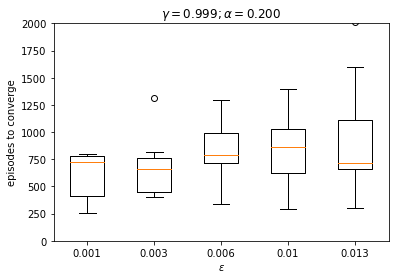

In [4]:
"""Q-learning algorithm implementation."""

import pandas
import numpy as np
import numpy.random as rnd
import gym
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt

def make_eps_greedy_policy(Q, eps, n):
    """Define a policy.
    Parameters
    ----------
    Q : array_like (n_states x n_actions)
        Action-values.
    eps : float
        Eps-greedy factor.
    n : integer
        Number of actions.
    Returns
    -------
    policy : function
        Function that returns actions given an input state (the present state).
    """
    def policy(state):
        """Define a set of actions.
        Parameters
        ----------
        state : tuple
            Present state on which depends our next action.
        Retuns
        ------
        A : array
            Probabilities for actions in the set of possible actions to be taken.
        """
        A = np.ones(n, dtype=float) * eps/n
        best = np.argmax(Q[state])
        A[best] += 1 - eps
        return A
    return policy

def q_learning_control(env, max_num_episodes, discount=1.0, eps=0.99, alpha=0.05):
    """Q-learning control.
    Parameters
    ----------
    env : OpenAI gym environment
        Environment which will be used in the simulation (CartPole-v0).
    max_num_episodes : int
        Max number of episodes to converge.
    discount : float
        Discount factor.
    eps : float
        Exploration rate (since we are using an epsilon-greedy policy).
    eps_decay : float
        Exploration rate decay over episodes.
    eps_min : float
        Min exploration rate reachable.
    Returns
    -------
    converged : bool
        True if the algorithm converged, False otherwise.
    num_episodes : int
        Number of episodes to converge.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    possible_actions = np.arange(env.action_space.n)
    converged = False
    returns = []

    for num_episodes in range(max_num_episodes):
        totalreward = 0     # total reward in this episodes (+1 each step)
        state = build_state(env.reset())
        policy = make_eps_greedy_policy(Q, eps, env.action_space.n)

        for t in itertools.count():
            probs = policy(state)
            action = rnd.choice(possible_actions, p=probs)

            # take the current action and observe the reward
            next_state, reward, done, _ = env.step(action)
            next_state = build_state(next_state)

            # if the cartpole system fell down during this episode
            if (done):
                # high penalization helps the convergence
                Q[state][action] += -200
                totalreward += reward
                returns.append(totalreward)
                break

            # update Q-values using Q-learning update rule
            max_action = np.argmax(Q[next_state])
            Q[state][action] = Q[state][action] + alpha*(reward + discount*Q[next_state][max_action] - Q[state][action])

            # append this step's reward
            totalreward += reward

            state = next_state

        # we are not decaying in the sensibility analysis
        #if i%100 == 0:
        #    eps *= eps_decay
        #    if (eps < eps_min):
        #        eps = eps_min

        # winning condition: last 100 episodes have a mean of WINNING_MEAN total reward
        mean = np.mean(returns[-100:])
        if mean >= WINNING_MEAN:
            converged = True
            break

    return converged, num_episodes

def build_state(state):
    """Discretize the state returned by the environment.
    Parameters
    ----------
    state : tuple
        State returned by OpenAI gym environment.
    Returns
    -------
    _ : tuple
        The correspondent discrete state.
    """
    return (np.digitize([state[0]], cart_position_bins)[0],
            np.digitize([state[1]], cart_velocity_bins)[0],
            np.digitize([state[2]], pole_angle_bins)[0],
            np.digitize([state[3]], angle_rate_bins)[0])

if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    max_num_episodes = 6000
    discount = 0.999
    eps = 0.001
    #eps_decay = 0.0
    #eps_min = 0.01
    alpha = 0.2

    NUM_ITERATIONS = 10
    WINNING_MEAN = 170
    EPS_ANALYSIS = 0
    ALPHA_ANALYSIS = 1
    DISCOUNT_ANALYSIS = 2
    mode = EPS_ANALYSIS

    # number of discrete states
    n_bins = 8
    n_bins_angle = 10

    # discrete states for each variable
    cart_position_bins = pandas.cut([-2.4, 2.4], bins=n_bins, retbins=True)[1][1:-1]
    cart_velocity_bins = pandas.cut([-1, 1], bins=n_bins, retbins=True)[1][1:-1]
    pole_angle_bins = pandas.cut([-2, 2], bins=n_bins_angle, retbins=True)[1][1:-1]
    angle_rate_bins = pandas.cut([-3.5, 3.5], bins=n_bins_angle, retbins=True)[1][1:-1]

    array_eps_to_conv = []
    if (mode == EPS_ANALYSIS):
        eval_array = [0.001,0.003,0.006,0.01,0.013]
    elif (mode == ALPHA_ANALYSIS):
        eval_array = [0.1,0.2,0.3,0.5,0.7]
    else:
        eval_array = [0.999,0.8,0.7,0.6,0.5]

    for t in range(NUM_ITERATIONS):
        array_temp = []
        print(t)

        for hyperparameter in eval_array:
            if (mode == EPS_ANALYSIS):
                has_converged, episodes_to_converge = q_learning_control(env, max_num_episodes, discount, hyperparameter, alpha)
            elif (mode == ALPHA_ANALYSIS):
                has_converged, episodes_to_converge = q_learning_control(env, max_num_episodes, discount, eps, hyperparameter)
            else:
                has_converged, episodes_to_converge = q_learning_control(env, max_num_episodes, hyperparameter, eps, alpha)

            array_temp.append(episodes_to_converge)
            print(hyperparameter, ")the system ", "has converged" if (has_converged) else "hasn't converged", " after ", episodes_to_converge, " episodes.")

        array_eps_to_conv.append(array_temp)

    array_eps_to_conv = np.array(array_eps_to_conv)
    fig = plt.figure()
    ax = fig.add_subplot(111)

    if (mode == EPS_ANALYSIS):
        title = r'$\gamma = {:.3f}; \alpha = {:.3f}$'.format(discount, alpha)
        label = r'$\epsilon$'
        name = 'eps_sensibility.png'
        ax.set_ylim((0,2000))
    elif (mode == ALPHA_ANALYSIS):
        title = r'$\gamma = {:.3f}; \epsilon = {:.3f}$'.format(discount, eps)
        label = r'$\alpha$'
        name = 'lr_sensibility.png'
        ax.set_ylim((0,1000))
    else:
        title = r'$\alpha = {:.3f}; \epsilon = {:.3f}$'.format(alpha, eps)
        label = r'$1-\gamma$'
        eval_array = [np.around(1-disc, decimals=4) for disc in eval_array]
        name = 'discount_sensibility.png'
        ax.set_ylim((0,1500))

    ax.set_title(title)
    ax.set_ylabel('episodes to converge')
    ax.set_xlabel(label)
    ax.boxplot(array_eps_to_conv, labels=eval_array)
    plt.savefig(name)

0
0.1 )the system  has converged  after  152  episodes.
0.2 )the system  has converged  after  596  episodes.
0.3 )the system  has converged  after  153  episodes.
0.5 )the system  has converged  after  310  episodes.
0.7 )the system  has converged  after  505  episodes.
1
0.1 )the system  has converged  after  241  episodes.
0.2 )the system  has converged  after  131  episodes.
0.3 )the system  has converged  after  391  episodes.
0.5 )the system  has converged  after  286  episodes.
0.7 )the system  has converged  after  372  episodes.
2
0.1 )the system  has converged  after  1043  episodes.
0.2 )the system  has converged  after  1079  episodes.
0.3 )the system  has converged  after  690  episodes.
0.5 )the system  has converged  after  709  episodes.
0.7 )the system  has converged  after  847  episodes.
3
0.1 )the system  has converged  after  826  episodes.
0.2 )the system  has converged  after  633  episodes.
0.3 )the system  has converged  after  696  episodes.
0.5 )the system  h

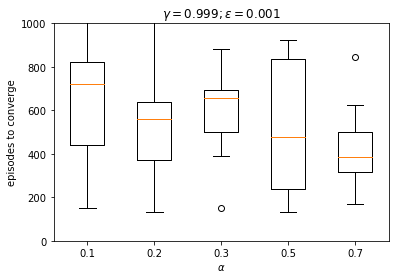

In [5]:
"""Q-learning algorithm implementation."""

import pandas
import numpy as np
import numpy.random as rnd
import gym
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt

def make_eps_greedy_policy(Q, eps, n):
    """Define a policy.
    Parameters
    ----------
    Q : array_like (n_states x n_actions)
        Action-values.
    eps : float
        Eps-greedy factor.
    n : integer
        Number of actions.
    Returns
    -------
    policy : function
        Function that returns actions given an input state (the present state).
    """
    def policy(state):
        """Define a set of actions.
        Parameters
        ----------
        state : tuple
            Present state on which depends our next action.
        Retuns
        ------
        A : array
            Probabilities for actions in the set of possible actions to be taken.
        """
        A = np.ones(n, dtype=float) * eps/n
        best = np.argmax(Q[state])
        A[best] += 1 - eps
        return A
    return policy

def q_learning_control(env, max_num_episodes, discount=1.0, eps=0.99, alpha=0.05):
    """Q-learning control.
    Parameters
    ----------
    env : OpenAI gym environment
        Environment which will be used in the simulation (CartPole-v0).
    max_num_episodes : int
        Max number of episodes to converge.
    discount : float
        Discount factor.
    eps : float
        Exploration rate (since we are using an epsilon-greedy policy).
    eps_decay : float
        Exploration rate decay over episodes.
    eps_min : float
        Min exploration rate reachable.
    Returns
    -------
    converged : bool
        True if the algorithm converged, False otherwise.
    num_episodes : int
        Number of episodes to converge.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    possible_actions = np.arange(env.action_space.n)
    converged = False
    returns = []

    for num_episodes in range(max_num_episodes):
        totalreward = 0     # total reward in this episodes (+1 each step)
        state = build_state(env.reset())
        policy = make_eps_greedy_policy(Q, eps, env.action_space.n)

        for t in itertools.count():
            probs = policy(state)
            action = rnd.choice(possible_actions, p=probs)

            # take the current action and observe the reward
            next_state, reward, done, _ = env.step(action)
            next_state = build_state(next_state)

            # if the cartpole system fell down during this episode
            if (done):
                # high penalization helps the convergence
                Q[state][action] += -200
                totalreward += reward
                returns.append(totalreward)
                break

            # update Q-values using Q-learning update rule
            max_action = np.argmax(Q[next_state])
            Q[state][action] = Q[state][action] + alpha*(reward + discount*Q[next_state][max_action] - Q[state][action])

            # append this step's reward
            totalreward += reward

            state = next_state

        # we are not decaying in the sensibility analysis
        #if i%100 == 0:
        #    eps *= eps_decay
        #    if (eps < eps_min):
        #        eps = eps_min

        # winning condition: last 100 episodes have a mean of WINNING_MEAN total reward
        mean = np.mean(returns[-100:])
        if mean >= WINNING_MEAN:
            converged = True
            break

    return converged, num_episodes

def build_state(state):
    """Discretize the state returned by the environment.
    Parameters
    ----------
    state : tuple
        State returned by OpenAI gym environment.
    Returns
    -------
    _ : tuple
        The correspondent discrete state.
    """
    return (np.digitize([state[0]], cart_position_bins)[0],
            np.digitize([state[1]], cart_velocity_bins)[0],
            np.digitize([state[2]], pole_angle_bins)[0],
            np.digitize([state[3]], angle_rate_bins)[0])

if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    max_num_episodes = 6000
    discount = 0.999
    eps = 0.001
    #eps_decay = 0.0
    #eps_min = 0.01
    alpha = 0.2

    NUM_ITERATIONS = 10
    WINNING_MEAN = 170
    EPS_ANALYSIS = 0
    ALPHA_ANALYSIS = 1
    DISCOUNT_ANALYSIS = 2
    mode = ALPHA_ANALYSIS

    # number of discrete states
    n_bins = 8
    n_bins_angle = 10

    # discrete states for each variable
    cart_position_bins = pandas.cut([-2.4, 2.4], bins=n_bins, retbins=True)[1][1:-1]
    cart_velocity_bins = pandas.cut([-1, 1], bins=n_bins, retbins=True)[1][1:-1]
    pole_angle_bins = pandas.cut([-2, 2], bins=n_bins_angle, retbins=True)[1][1:-1]
    angle_rate_bins = pandas.cut([-3.5, 3.5], bins=n_bins_angle, retbins=True)[1][1:-1]

    array_eps_to_conv = []
    if (mode == EPS_ANALYSIS):
        eval_array = [0.001,0.003,0.006,0.01,0.013]
    elif (mode == ALPHA_ANALYSIS):
        eval_array = [0.1,0.2,0.3,0.5,0.7]
    else:
        eval_array = [0.999,0.8,0.7,0.6,0.5]

    for t in range(NUM_ITERATIONS):
        array_temp = []
        print(t)

        for hyperparameter in eval_array:
            if (mode == EPS_ANALYSIS):
                has_converged, episodes_to_converge = q_learning_control(env, max_num_episodes, discount, hyperparameter, alpha)
            elif (mode == ALPHA_ANALYSIS):
                has_converged, episodes_to_converge = q_learning_control(env, max_num_episodes, discount, eps, hyperparameter)
            else:
                has_converged, episodes_to_converge = q_learning_control(env, max_num_episodes, hyperparameter, eps, alpha)

            array_temp.append(episodes_to_converge)
            print(hyperparameter, ")the system ", "has converged" if (has_converged) else "hasn't converged", " after ", episodes_to_converge, " episodes.")

        array_eps_to_conv.append(array_temp)

    array_eps_to_conv = np.array(array_eps_to_conv)
    fig = plt.figure()
    ax = fig.add_subplot(111)

    if (mode == EPS_ANALYSIS):
        title = r'$\gamma = {:.3f}; \alpha = {:.3f}$'.format(discount, alpha)
        label = r'$\epsilon$'
        name = 'eps_sensibility.png'
        ax.set_ylim((0,2000))
    elif (mode == ALPHA_ANALYSIS):
        title = r'$\gamma = {:.3f}; \epsilon = {:.3f}$'.format(discount, eps)
        label = r'$\alpha$'
        name = 'lr_sensibility.png'
        ax.set_ylim((0,1000))
    else:
        title = r'$\alpha = {:.3f}; \epsilon = {:.3f}$'.format(alpha, eps)
        label = r'$1-\gamma$'
        eval_array = [np.around(1-disc, decimals=4) for disc in eval_array]
        name = 'discount_sensibility.png'
        ax.set_ylim((0,1500))

    ax.set_title(title)
    ax.set_ylabel('episodes to converge')
    ax.set_xlabel(label)
    ax.boxplot(array_eps_to_conv, labels=eval_array)
    plt.savefig(name)